In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here
from itertools import chain
import pydicom

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assessments. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
1225,00006468_003.png,No Finding,3,6468,021Y,M,AP,2048,2500,0.171,0.171
3469,00017123_000.png,No Finding,0,17123,041Y,M,PA,2992,2991,0.143,0.143
3948,00019486_000.png,Cardiomegaly,0,19486,049Y,M,PA,2992,2991,0.143,0.143


In [3]:
## EDA
# Todo 
all_xray_df['Patient Gender'].value_counts()

M    63340
F    48780
Name: Patient Gender, dtype: int64

In [4]:
all_xray_df['Patient Age'].describe()

count    112120.000000
mean         46.901463
std          16.839923
min           1.000000
25%          35.000000
50%          49.000000
75%          59.000000
max         414.000000
Name: Patient Age, dtype: float64

The max value for Patient Age is 414, definitely outliers.  Check the distribution for Patient Age < 100:

(array([ 1803.,  5021., 12798., 14580., 18664., 26481., 20790.,  9793.,
         1917.,   257.]),
 array([ 1. , 10.4, 19.8, 29.2, 38.6, 48. , 57.4, 66.8, 76.2, 85.6, 95. ]),
 <a list of 10 Patch objects>)

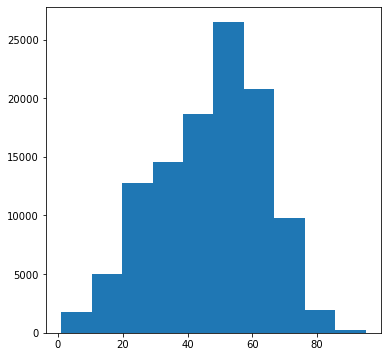

In [5]:
plt.figure(figsize=(6, 6))
plt.hist(all_xray_df[all_xray_df['Patient Age'] < 100]['Patient Age'])

In [6]:
## Collect all labels
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
16080,00004291_003.png,No Finding,3,4291,39,F,PA,2048,2500,0.168000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
105408,00028324_001.png,Mass|Pleural_Thickening,1,28324,62,F,PA,1842,2021,0.194311,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
34291,00009005_000.png,No Finding,0,9005,40,F,PA,2048,2500,0.168000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Recheck age distribution for Patient Age < 100 and Pneumonia == 1:

(array([ 41.,  85., 174., 203., 196., 243., 266., 175.,  39.,   8.]),
 array([ 2. , 10.8, 19.6, 28.4, 37.2, 46. , 54.8, 63.6, 72.4, 81.2, 90. ]),
 <a list of 10 Patch objects>)

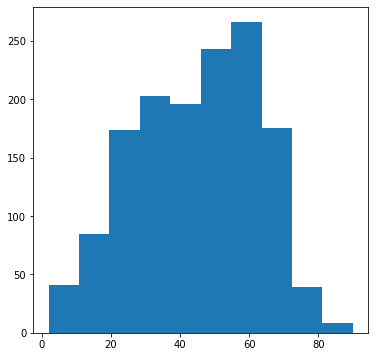

In [7]:
plt.figure(figsize=(6, 6))
plt.hist(all_xray_df[(all_xray_df['Patient Age'] < 100) & (all_xray_df['Pneumonia'] == 1)]['Patient Age'])

In [8]:
all_xray_df['View Position'].value_counts()

PA    67310
AP    44810
Name: View Position, dtype: int64

In [9]:
all_xray_df['Pneumonia'].value_counts()

0.0    110689
1.0      1431
Name: Pneumonia, dtype: int64

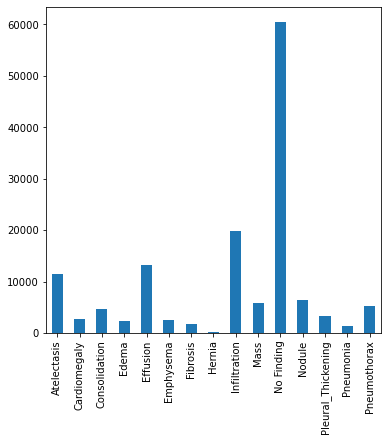

In [10]:
plt.figure(figsize=(6, 6))
all_xray_df[all_labels].sum().plot(kind='bar')

Except No Finding, Infiltration, Effusion, and Atelectasis are top 3.  Recheck disease distribution for Pneumonia == 1:

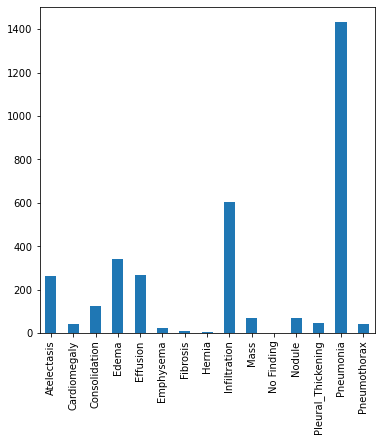

In [11]:
plt.figure(figsize=(6, 6))
all_xray_df[all_xray_df['Pneumonia'] == 1][all_labels].sum().plot(kind='bar')

In [12]:
all_xray_df[all_labels].sum().sum() / len(all_xray_df[all_xray_df['No Finding'] == 0])

2.734538920767403

By performing EDA, there is unbalance existing in the dataset, so data preprocessing should be applied next.  Use sample_labels.csv for pixel-level assessments:

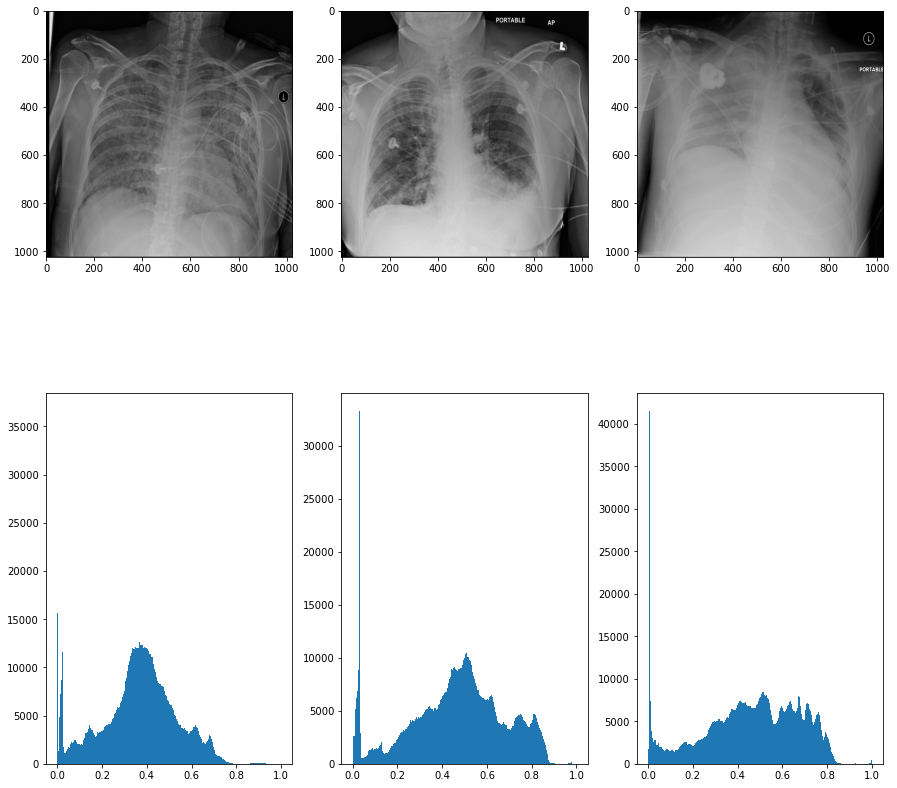

In [16]:
all_image_paths = {os.path.basename(x): x for x in glob(os.path.join('/data','images*', '*', '*.png'))}

images = []
for idx, img in all_xray_df[all_xray_df.Pneumonia==1].sample(3).iterrows():
    file_name = img['Image Index']
    images.append(plt.imread(all_image_paths.get(file_name)))
    
f, axes = plt.subplots(2, 3, figsize=(15, 15))

for i, image in enumerate(images):  
    axes[0, i].imshow(image, cmap='gray') 
    axes[1, i].hist(image.ravel(), bins=256)

The intensity distribution varies a lot, and normalization is required therefore.